## Load Libraries

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools as it
import os.path as osp
%matplotlib inline
import os
import cv2
import urllib

In [0]:
from google.colab import drive
drive.mount('/gdrive') # will ask for authorization

In [0]:
weights_path = '/gdrive/My Drive/ML Data/AlexNet/bvlc_alexnet.npy'
models_path = '/gdrive/My Drive/ML Data/AlexNet/saved_models'

In [0]:
!cp "/gdrive/My Drive/ML Data/AlexNet/caffe_classes.py" "caffe_classes.py"
from caffe_classes import class_names

## AlexNet

  1.  Create the architecture of AlexNet (that matches the weights someone else learned)
  2.  Use those learned weights to initialize our network.
  3. Weights can be downloaded from http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/
  
Note that the initial training of the AlexNet in the academic paper took about six days on a machine with two highend GPUs.

In [0]:
pretrained_weights = np.load(weights_path, encoding='bytes').item()

Examing `pretrained_weights` and `class_names`

In [6]:
for elem in ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']:
  print(elem, 'weights:', pretrained_weights[elem][0].shape)
  print(elem, 'bias:', pretrained_weights[elem][1].shape)

conv1 weights: (11, 11, 3, 96)
conv1 bias: (96,)
conv2 weights: (5, 5, 48, 256)
conv2 bias: (256,)
conv3 weights: (3, 3, 256, 384)
conv3 bias: (384,)
conv4 weights: (3, 3, 192, 384)
conv4 bias: (384,)
conv5 weights: (3, 3, 192, 256)
conv5 bias: (256,)
fc6 weights: (9216, 4096)
fc6 bias: (4096,)
fc7 weights: (4096, 4096)
fc7 bias: (4096,)
fc8 weights: (4096, 1000)
fc8 bias: (1000,)


In [7]:
print('Number of labels:', len(class_names))
print('Label example:', class_names[10])

Number of labels: 1000
Label example: brambling, Fringilla montifringilla


## Convolution Layers

The 'old' way of creating a convolutional layer (weights and biases set to random values and a constant, respectively).

In [0]:
def random_init_conv_layer(incoming, num_kernels, kernel_sz, 
                           strides=[1, 1], padding='SAME',
                           bval=0.01, 
                           activation_fn=tf.nn.relu, 
                           name=None):
    
    prev_outshape = incoming.shape.dims[-1].value
    kshape = kernel_sz + [prev_outshape, num_kernels]

    fan_in = np.prod(incoming.shape[1:]).value
    xavier_stddev = np.sqrt(2.0 / fan_in)
    
    strides = [1] + strides + [1]
    
    with tf.variable_scope(name, 'conv_layer'):
        w = tf.Variable(tf.truncated_normal(kshape, stddev=xavier_stddev), name='kernel')
        b = tf.Variable(tf.constant(bval, shape=[num_kernels]), name='bias')
        conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
        z = tf.nn.bias_add(conv, b)
        return z if activation_fn is None else activation_fn(z)

#### A convolution layer that uses explictly given NumPy arrays to initialize its weights and biases.

In [0]:
# pt stands for "pre-trained"
def pt_conv_layer(incoming, init_weight, init_bias,
                  strides=[1, 1], padding='SAME',
                  activation_fn=tf.nn.relu, 
                  name=None):
    'expects to be given numpy arrays or tensors for weight/bias'
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'conv_layer'):
        w = tf.Variable(init_weight, name='kernel')
        b = tf.Variable(init_bias, name='bias')
        conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
        z = tf.nn.bias_add(conv, b)
        a = activation_fn(z) if activation_fn is not None else z
        return a

## Split Convolution
To mimic the architecture of AlexNet, we can split the convolution layer.  When AlexNet was trained for real, this is the portion that got divided between two GPUs.  This isn't 100% necessary but since filter relationships are sparse, the effect of filter groups is to learn with a block-diagonal structured sparsity on the channel dimension. In effect, the filters with high correlation are learned in a more structured way which has a regularization effect.

In [0]:
# pt stands for "pre-trained"
def pt_split_conv_layer(incoming, init_weight, init_bias, 
                        strides=[1, 1], padding='SAME',
                        activation_fn=tf.nn.relu, 
                        name=None):
    strides = [1] + strides + [1]
    with tf.variable_scope(name, 'split_conv_layer'):
        w = tf.Variable(init_weight, name='kernel')
        b = tf.Variable(init_bias, name='bias')
        
        if True: # always split
            i_a, i_b = tf.split(incoming, 2, 3, name='split_inputs')
            w_a, w_b = tf.split(w, 2, 3, name='split_weights')

            conv_a = tf.nn.conv2d(i_a, w_a, strides, padding, name='conv_a')
            conv_b = tf.nn.conv2d(i_b, w_b, strides, padding, name='conv_b')
            
            merge = tf.concat([conv_a, conv_b], 3)
        else:
            conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')        
        
        z = tf.nn.bias_add(merge, b)
        a = activation_fn(z) if activation_fn is not None else z
        return a


## AlexNet Utility Layers

For information on where the magic constants in `alex_lrn_layer` come from, see: http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/myalexnet_forward_newtf.py

In [0]:
# pt stands for "pre-trained"
def pt_alex_fc_layer(incoming, init_weights, init_biases, name=None):
    'expects to be given numpy arrays or tensors for weight/bias'
    with tf.name_scope('fully_connected'):
        return tf.nn.relu_layer(incoming, init_weights, init_biases, name=name)
    
def alex_lrn_layer(inputs):
    'lrn with some magic constants'
    return tf.nn.local_response_normalization(inputs, 2, 1.0, 2e-05, 0.75)

## Pooling and Flatten Layers

In [0]:
def pool_layer(incoming, ksize, strides, padding='VALID',
                pool_fn=tf.nn.max_pool, name=None):
    # pooling layer with stride padding
    ksize = [1] + ksize + [1]
    strides = [1] + strides + [1]    
    with tf.variable_scope(name, 'pool_layer'):
        return pool_fn(incoming, ksize, strides, padding)
    
def flatten(incoming, name=None):
    flat_shape = [-1, np.prod(incoming.shape[1:]).value]
    return tf.reshape(incoming, flat_shape)

## Defining the Main AlexNet Graph

And, here are the layer weight sizes that we loaded above:

    conv1: (11, 11, 3, 96)
    conv2: (5, 5, 48, 256)
    conv3: (3, 3, 256, 384)
    conv4: (3, 3, 192, 384)
    conv5: (3, 3, 192, 256)
    fc6: (9216, 4096)
    fc7: (4096, 4096)
    fc8: (4096, 1000)

The layer structure is (note, lrn and pool don't have weights):
    *  conv, lrn, pool
    *  split, lrn, pool
    *  conv, split, split, pool, flat
    *  full, full, and a special fully connected: `tf.nn.xw_plus_b`.
    *  http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/myalexnet_forward_newtf.py

In [0]:
def alexnet(images, init_weights):
  """
  init_weights is a dictionary with pretrained weights
  """
  with tf.name_scope('alexnet_model'):
      conv_1 = pt_conv_layer(images, init_weights['conv1'][0],
                             init_weights['conv1'][1], [4, 4],
                             padding='VALID', name='conv_1')
      
      lrn_1 = alex_lrn_layer(conv_1)
      
      pool_1 = pool_layer(lrn_1, [3, 3], [2, 2], name='pool_1')
      
      conv_2 = pt_split_conv_layer(pool_1, init_weights['conv2'][0],
                             init_weights['conv2'][1], [1, 1],
                             padding='SAME', name='conv_2')
      
      lrn_2 = alex_lrn_layer(conv_2)
      
      pool_2 = pool_layer(lrn_2, [3, 3], [2, 2], name='pool_1')
      
      conv_3 = pt_conv_layer(pool_2, init_weights['conv3'][0],
                             init_weights['conv3'][1], [1, 1],
                             padding='SAME', name='conv_3')
      
      conv_4 = pt_split_conv_layer(conv_3, init_weights['conv4'][0],
                             init_weights['conv4'][1], [1, 1],
                             padding='SAME', name='conv_4')
      
      conv_5 = pt_split_conv_layer(conv_4, init_weights['conv5'][0],
                             init_weights['conv5'][1], [1, 1],
                             padding='SAME', name='conv_5')
      
      pool_5 = pool_layer(conv_5, [3, 3], [2, 2], name='pool_5')

      flat = flatten(pool_5, name='flat')
      
      fc_6 = pt_alex_fc_layer(flat, init_weights['fc6'][0],
                      init_weights['fc6'][1], name='fc_6')
      
      fc_7 = pt_alex_fc_layer(fc_6, init_weights['fc7'][0],
                      init_weights['fc7'][1], name='fc_7')

      fc_8 = tf.nn.xw_plus_b(fc_7, init_weights['fc8'][0],
                             init_weights['fc8'][1], name='fc_8')

  return fc_8

In [0]:
class AlexNet_Model:
    def __init__(s, img_height, img_width, init_weights):  # non-standard, for abbreviation
        s.graph = tf.Graph()
        with s.graph.as_default():
            with tf.name_scope('inputs'):
                
                s.images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name="images")
                
            with tf.name_scope('rescale'):
                s.scaled_images = tf.image.resize_images(s.images, [img_height, img_width])
                
            s.logits = alexnet(s.scaled_images, init_weights)
                        
            with tf.name_scope('prediction'):
                s.softmax    = tf.nn.softmax(s.logits, name="softmax")
                s.prediction = tf.cast(tf.argmax(s.softmax, 1), tf.int32)

            s.init = tf.global_variables_initializer()
            
        s.session = tf.Session(graph=s.graph)
        s.session.run(s.init)

    def save(s, models_path):
        with s.graph.as_default():
            saver = tf.train.Saver()
            saver.save(s.session, osp.join(models_path, 'model'))
        
    def predict(s, test_dict):
        pred, prob = s.session.run([s.prediction, s.softmax], feed_dict=test_dict)
        return pred, prob

Instantiate the model.

In [0]:
mm = AlexNet_Model(227, 227, init_weights=pretrained_weights)

Sve the model.

In [0]:
#Uncomment to save predefined model.
#mm.save(models_path)

Check model validity.

In [0]:
image_dir = "/gdrive/My Drive/ML Data/AlexNet/Images/"
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpeg')]

In [18]:
#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))
print('Number of images:', len(imgs))

Number of images: 6


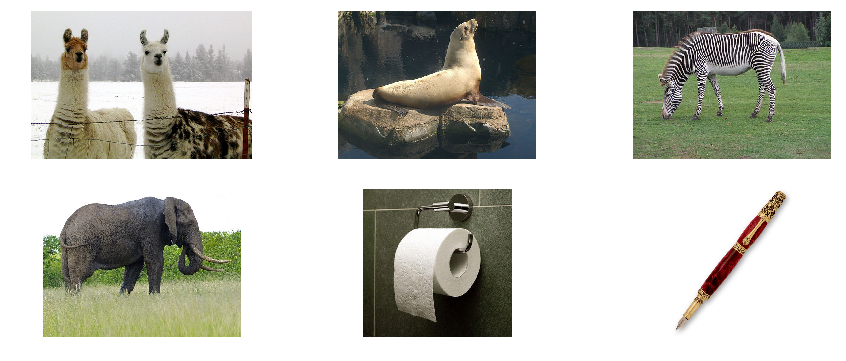

In [19]:
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(2,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [0]:
def get_prediction(image):
  # Convert image to float32 and resize to (227x227)
    img = cv2.resize(image.astype(np.float32), (227,227))
    imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)
    # Subtract the ImageNet mean
    img -= imagenet_mean
    # Reshape as needed to feed into model
    img = img.reshape((227,227,3))
    img_batch = np.expand_dims(img, 0)
    pred, probs = mm.predict({mm.images: img_batch})
    class_name = class_names[np.argmax(probs)]
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
    plt.axis('off')

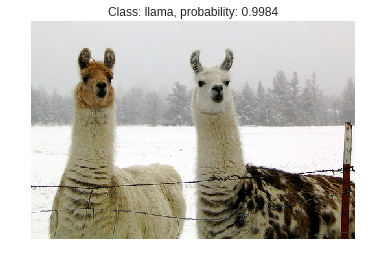

In [21]:
get_prediction(imgs[0])

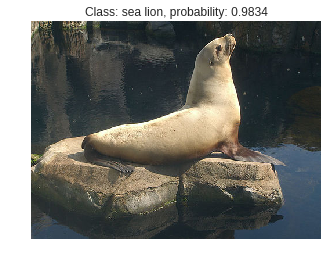

In [22]:
get_prediction(imgs[1])

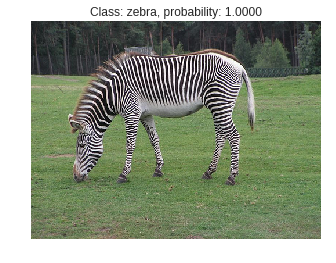

In [23]:
get_prediction(imgs[2])

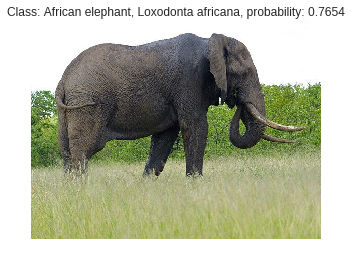

In [24]:
get_prediction(imgs[3])

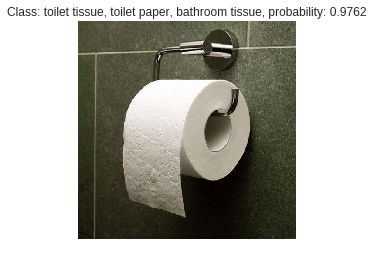

In [25]:
get_prediction(imgs[4])

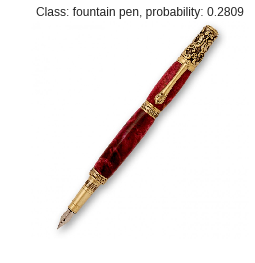

In [26]:
get_prediction(imgs[5])